In [9]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os

In [10]:
df = pd.read_csv("data/sequence_with_lag_features_cancel_out.csv")
df["is_holiday"] = df["is_holiday"].replace({False: 0, True: 1})
df["1y_holiday_diff"] = df["1y_holiday_diff"].fillna(0)
df.drop(
    columns=[
        "lag_1_spending",
        "lag_2_spending",
        "lag_3_spending",
        "lag_5_spending",
        "lag_6_spending",
        "lag_7_spending",
        "lag_9_spending",
        "lag_11_spending",
        "lag_12_spending",
        "weekend_spend_ratio",
        "correlation_with_trend",
        "risk_of_default_score",
        "risk_level",
        "Cluster",
    ],
    inplace=True,
)

df.rename(columns={"user_total_spending": "total_amount"}, inplace=True)
df.head(10)

/tmp/nix-shell.GonuuB/ipykernel_3381780/1581709192.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["is_holiday"] = df["is_holiday"].replace({False: 0, True: 1})


,user_id,year_month,txn_count_prev,total_expense_prev,mean_amount,user_gender,user_current_age,user_yearly_income,user_per_capita_income,user_credit_score,...,income_per_card,multi_card_user,income_utilization_ratio,credit_utilization_ratio,oldest_card_age_years,percentage_prev_monthly_expense_as_yearly,percentage_prev_monthly_expense_as_capita,1y_holiday_diff,is_holiday,total_amount
0,0,2015-01-01,128.0,6185.2,53.0,0,33,59613.0,29237.0,763,...,59613.0,0,1.1,0.0,18,10.4,21.2,-1252.72,1,6185.2
1,0,2015-02-01,99.0,5249.9,49.2,0,33,59613.0,29237.0,763,...,59613.0,0,1.1,0.0,18,8.8,18.0,-739.90,1,5249.9
2,0,2015-03-01,86.0,4229.7,45.5,0,33,59613.0,29237.0,763,...,59613.0,0,1.1,0.0,18,7.1,14.5,0.00,0,4229.7
3,0,2015-04-01,101.0,4595.4,47.8,0,33,59613.0,29237.0,763,...,59613.0,0,1.1,0.0,18,7.7,15.7,0.00,0,4595.4
4,0,2015-05-01,96.0,4586.5,50.6,0,33,59613.0,29237.0,763,...,59613.0,0,1.1,0.0,18,7.7,15.7,-1420.57,1,4586.5
5,0,2015-06-01,116.0,5864.1,57.6,0,33,59613.0,29237.0,763,...,59613.0,0,1.1,0.0,18,9.8,20.1,0.00,0,5864.1
6,0,2015-07-01,106.0,6104.9,59.8,0,33,59613.0,29237.0,763,...,59613.0,0,1.1,0.0,18,10.2,20.9,-1133.53,1,6104.9
7,0,2015-08-01,92.0,5504.1,48.8,0,33,59613.0,29237.0,763,...,59613.0,0,1.1,0.0,18,9.2,18.8,0.00,0,5504.1
8,0,2015-09-01,103.0,5029.5,56.7,0,33,59613.0,29237.0,763,...,59613.0,0,1.1,0.0,18,8.4,17.2,67.42,1,5029.5
9,0,2015-10-01,94.0,5329.9,58.9,0,33,59613.0,29237.0,763,...,59613.0,0,1.1,0.0,18,8.9,18.2,-495.02,1,5329.9


In [11]:
# Load fresh data
print(f"Loaded data: {df.shape[0]:,} rows, {df.shape[1]} columns")
print(f"Original total_amount: mean=${df['total_amount'].mean():,.2f}, std=${df['total_amount'].std():,.2f}")

Loaded data: 69,814 rows, 27 columns
Original total_amount: mean=$3,900.49, std=$2,519.41


In [12]:
# Convert categorical variables
df["user_gender"] = df["user_gender"].map({"M": 1, "F": 0})

# Replace infinity values with NaN, then fill with 0
df = df.replace([np.inf, -np.inf], np.nan)

# Handle missing values
df = df.fillna(0)

In [13]:
# Inspect data for problematic values
print("Data shape:", df.shape)
print("\nChecking for inf values:")
print(df.isin([np.inf, -np.inf]).sum())
print("\nChecking for NaN values:")
print(df.isna().sum())
print("\nData types:")
print(df.dtypes)
print("\nBasic statistics:")
print(df.describe())

Data shape: (69814, 27)

Checking for inf values:
user_id                                      0
year_month                                   0
txn_count_prev                               0
total_expense_prev                           0
mean_amount                                  0
user_gender                                  0
user_current_age                             0
user_yearly_income                           0
user_per_capita_income                       0
user_credit_score                            0
user_total_debt                              0
user_birth_month                             0
card_num_cards_issued                        0
user_latitude                                0
user_longitude                               0
year_to_retirement                           0
debt_to_yearly_income_ratio                  0
income_per_card                              0
multi_card_user                              0
income_utilization_ratio                     0
credit_uti

In [14]:
df["year_month"] = pd.to_datetime(df["year_month"])

"""
Dataset split strategy:
- For training: use only 2014-2017 data
- For validation: use data up to 2018 (so users have 2014-2018 history to predict in 2018)
- For testing: use all data up to 2019 (so users have 2014-2019 history to predict in 2019)
"""

train_start = pd.Timestamp("2014-01-01")
train_end = pd.Timestamp("2017-12-31")
val_target_start = pd.Timestamp("2018-01-01")
val_end = pd.Timestamp("2018-12-31")
test_target_start = pd.Timestamp("2019-01-01")
test_end = pd.Timestamp("2019-09-30")

# For training: only use 2014-2017
train_df = df[(df["year_month"] >= train_start) & (df["year_month"] <= train_end)].copy()

# For validation: use 2018 data only (after training period)
val_df = df[(df["year_month"] > train_end) & (df["year_month"] <= val_end)].copy()

# For testing: use 2019 data only (after validation period)
test_df = df[(df["year_month"] > val_end) & (df["year_month"] <= test_end)].copy()

print(f"Data shapes: train={len(train_df)}, val={len(val_df)}, test={len(test_df)}")
print(f"Train period: {train_df['year_month'].min()} to {train_df['year_month'].max()}")
print(f"Val period: {val_df['year_month'].min()} to {val_df['year_month'].max()}")
print(f"Test period: {test_df['year_month'].min()} to {test_df['year_month'].max()}")

Data shapes: train=43305, val=14454, test=10852
Train period: 2015-01-01 00:00:00 to 2017-12-01 00:00:00
Val period: 2018-01-01 00:00:00 to 2018-12-01 00:00:00
Test period: 2019-01-01 00:00:00 to 2019-09-01 00:00:00


In [15]:
num_cols = [
    "txn_count_prev",
    "total_expense_prev",
    "mean_amount",
    "user_current_age",
    "user_yearly_income",
    "user_per_capita_income",
    "user_credit_score",
    "user_total_debt",
    "user_birth_month",
    "card_num_cards_issued",
    "user_latitude",
    "user_longitude",
    "year_to_retirement",
    "debt_to_yearly_income_ratio",
    "income_per_card",
    "income_utilization_ratio",
    "credit_utilization_ratio",
    "oldest_card_age_years",
    "percentage_prev_monthly_expense_as_yearly",
    "percentage_prev_monthly_expense_as_capita",
    "1y_holiday_diff",
    "is_holiday",
    "total_amount",  # Add target variable for scaling
]

# Scale features and target together, then save target scaler params separately
scaler = StandardScaler()
train_df[num_cols] = scaler.fit_transform(train_df[num_cols])
val_df[num_cols] = scaler.transform(val_df[num_cols])
test_df[num_cols] = scaler.transform(test_df[num_cols])

# Store target scaler parameters for inverse transform
target_idx = num_cols.index("total_amount")
target_mean = scaler.mean_[target_idx]
target_std = scaler.scale_[target_idx]
print(f"✅ Scaling complete. Target (total_amount) stats: mean=${target_mean:,.2f}, std=${target_std:,.2f}")

✅ Scaling complete. Target (total_amount) stats: mean=$3,906.69, std=$2,527.53


In [16]:
class TransactionDataset(Dataset):
    def __init__(
        self,
        df,
        seq_len=12,
        target_col="total_amount",
        feature_cols=None,
        store_metadata=False,
        target_start=None,
        target_end=None,
    ):
        self.df = df.sort_values(["user_id", "year_month"]).reset_index(drop=True)
        self.seq_len = seq_len
        self.target_col = target_col
        self.store_metadata = store_metadata
        self.feature_cols = feature_cols

        # Get valid indices (sequences with seq_len history)
        self.indices = []
        self.metadata = [] if store_metadata else None

        for user_id in df["user_id"].unique():
            user_df = df[df["user_id"] == user_id].reset_index(drop=True)
            for i in range(self.seq_len, len(user_df)):
                target_date = user_df.iloc[i]["year_month"]

                # Filter by target date range if specified
                if target_start is not None and target_date < target_start:
                    continue
                if target_end is not None and target_date > target_end:
                    continue

                self.indices.append((user_id, i))
                if store_metadata:
                    self.metadata.append({"user_id": user_id, "year_month": target_date})

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        user_id, end_idx = self.indices[idx]
        user_df = self.df[self.df["user_id"] == user_id].reset_index(drop=True)

        # Get sequence and target
        seq = user_df.iloc[end_idx - self.seq_len : end_idx][self.feature_cols].values
        target = user_df.iloc[end_idx][self.target_col]

        return torch.FloatTensor(seq), torch.FloatTensor([target])

In [17]:
class TransformerAmountPredictor(nn.Module):
    def __init__(self, num_features, hidden_dim=128, num_layers=2, nhead=4, dropout=0.2):
        super().__init__()
        self.input_proj = nn.Linear(num_features, hidden_dim)
        # Learnable positional encoding, assuming max sequence length of 50 (window_size is 12)
        self.pos_embedding = nn.Parameter(torch.randn(1, 50, hidden_dim) * 0.01)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim, nhead=nhead, dim_feedforward=hidden_dim * 4, dropout=dropout, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # x: [batch, seq_len, num_features]
        B, L, _ = x.shape
        x = self.input_proj(x) + self.pos_embedding[:, :L, :]
        out = self.transformer_encoder(x)
        last_out = out[:, -1, :]  # [batch, hidden_dim]
        y_pred = self.fc(last_out)  # [batch, 1]
        return y_pred.squeeze(-1)


class LSTMAmountPredictor(nn.Module):
    def __init__(self, num_features, hidden_dim=128, num_layers=2, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=num_features,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
        )
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # x: [batch, seq_len, num_features]
        out, _ = self.lstm(x)
        last_out = out[:, -1, :]  # [batch, hidden_dim]
        y_pred = self.fc(last_out)  # [batch, 1]
        return y_pred.squeeze(-1)

In [18]:
feature_cols = [
    "txn_count_prev",
    "total_expense_prev",
    "mean_amount",
    "user_current_age",
    "user_gender",
    "user_yearly_income",
    "user_per_capita_income",
    "user_credit_score",
    "user_total_debt",
    "user_birth_month",
    "card_num_cards_issued",
    "user_latitude",
    "user_longitude",
    "year_to_retirement",
    "debt_to_yearly_income_ratio",
    "income_per_card",
    "multi_card_user",
    "income_utilization_ratio",
    "credit_utilization_ratio",
    "oldest_card_age_years",
    "percentage_prev_monthly_expense_as_yearly",
    "percentage_prev_monthly_expense_as_capita",
    "1y_holiday_diff",
    "is_holiday",
]

In [19]:
# Hyperparameters - Adjusted to reduce overfitting
SEQ_LEN = 12  # 12 months of history to predict next month
BATCH_SIZE = 128  # Increased batch size for better generalization
HIDDEN_DIM = 64  # Reduced from 128 to decrease model capacity
NUM_LAYERS = 2
NHEAD = 4
DROPOUT = 0.4  # Increased from 0.2 for stronger regularization
LEARNING_RATE = 0.0005  # Transformer learning rate
WEIGHT_DECAY = 1e-4  # L2 regularization
EPOCHS = 50
PATIENCE = 6

# Choose active model: 'transformer' or 'lstm'
ACTIVE_MODEL = "lstm"
print(f"Active model: {ACTIVE_MODEL}")

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
print(f"Using device: {device}")

# Get number of features
NUM_FEATURES = len(feature_cols)
print(f"Number of features: {NUM_FEATURES}")

# Initialize transformer model
transformer_model = TransformerAmountPredictor(
    num_features=NUM_FEATURES, hidden_dim=HIDDEN_DIM, num_layers=NUM_LAYERS, nhead=NHEAD, dropout=DROPOUT
).to(device)

# Initialize LSTM model
lstm_model = LSTMAmountPredictor(
    num_features=NUM_FEATURES, hidden_dim=HIDDEN_DIM, num_layers=NUM_LAYERS, dropout=DROPOUT
).to(device)

# Models dict
models = {
    "transformer": transformer_model,
    "lstm": lstm_model,
}

# Optimizers per model
optimizers = {
    "transformer": torch.optim.Adam(transformer_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY),
    "lstm": torch.optim.Adam(lstm_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY),
}

# Schedulers per model
schedulers = {
    "transformer": torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizers["transformer"], mode="min", factor=0.5, patience=3
    ),
    "lstm": torch.optim.lr_scheduler.ReduceLROnPlateau(optimizers["lstm"], mode="min", factor=0.5, patience=3),
}

# Epoch / patience selection based on active model
MODEL_EPOCHS = EPOCHS if ACTIVE_MODEL == "transformer" else EPOCHS
MODEL_PATIENCE = PATIENCE if ACTIVE_MODEL == "transformer" else PATIENCE

criterion = nn.MSELoss()

print(f"Configured {ACTIVE_MODEL} with epochs={MODEL_EPOCHS}, patience={MODEL_PATIENCE}")

Active model: lstm
Using device: cpu
Number of features: 24


amdgpu.ids: No such file or directory


Configured lstm with epochs=50, patience=6


In [21]:
# Create datasets with metadata storage and target date filtering
# Train: predict for any month with 12-month history (2015-01 onwards in 2014-2017 data)
train_dataset = TransactionDataset(
    train_df, seq_len=SEQ_LEN, target_col="total_amount", feature_cols=feature_cols, store_metadata=True
)

# Val: For 2018 predictions, we need 12 months of history (from 2017)
# So we use train+val data, but only create predictions for 2018
val_full_df = pd.concat([train_df, val_df], ignore_index=True)
val_dataset = TransactionDataset(
    val_full_df,
    seq_len=SEQ_LEN,
    target_col="total_amount",
    feature_cols=feature_cols,
    store_metadata=True,
    target_start=pd.Timestamp("2018-01-01"),
    target_end=pd.Timestamp("2018-12-31"),
)

# Test: For 2019 predictions, we need 12 months of history (from 2018)
# So we use train+val+test data, but only create predictions for 2019
test_full_df = pd.concat([train_df, val_df, test_df], ignore_index=True)
test_dataset = TransactionDataset(
    test_full_df,
    seq_len=SEQ_LEN,
    target_col="total_amount",
    feature_cols=feature_cols,
    store_metadata=True,
    target_start=pd.Timestamp("2019-01-01"),
    target_end=pd.Timestamp("2019-09-30"),
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [20]:
active_model = models[ACTIVE_MODEL]
optimizer = optimizers[ACTIVE_MODEL]
scheduler = schedulers[ACTIVE_MODEL]

best_val_loss = float("inf")
patience_counter = 0
MODEL_FILENAME = f"best_{ACTIVE_MODEL}.pt"

if os.path.isfile(MODEL_FILENAME):
    state_dict = torch.load(MODEL_FILENAME, map_location=device, weights_only=True)
    active_model.load_state_dict(state_dict)
    print(f"Loaded existing {MODEL_FILENAME} (weights only). Continuing training from epoch 0.")
else:
    print(f"No existing {MODEL_FILENAME} found. Starting fresh training.")

train_history = {"train_loss": [], "val_loss": [], "test_loss": []}

for epoch in range(MODEL_EPOCHS):
    active_model.train()
    train_losses = []
    for X, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{MODEL_EPOCHS} [Train-{ACTIVE_MODEL}]"):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        preds = active_model(X)
        loss = criterion(preds, y.squeeze())
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    avg_train_loss = np.mean(train_losses)

    # Validation
    active_model.eval()
    val_losses = []
    with torch.no_grad():
        for X, y in tqdm(val_loader, desc=f"Epoch {epoch+1}/{MODEL_EPOCHS} [Val]"):
            X, y = X.to(device), y.to(device)
            preds = active_model(X)
            loss = criterion(preds, y.squeeze())
            val_losses.append(loss.item())
    avg_val_loss = np.mean(val_losses)

    # Test (monitor only)
    test_losses = []
    with torch.no_grad():
        for X, y in tqdm(test_loader, desc=f"Epoch {epoch+1}/{MODEL_EPOCHS} [Test]"):
            X, y = X.to(device), y.to(device)
            preds = active_model(X)
            loss = criterion(preds, y.squeeze())
            test_losses.append(loss.item())
    avg_test_loss = np.mean(test_losses)

    train_history["train_loss"].append(avg_train_loss)
    train_history["val_loss"].append(avg_val_loss)
    train_history["test_loss"].append(avg_test_loss)

    # Scheduler step
    scheduler.step(avg_val_loss)

    print(
        f"\n📘 Epoch {epoch+1:02d} ({ACTIVE_MODEL}) | Train: {avg_train_loss:.6f} | Val: {avg_val_loss:.6f} | Test: {avg_test_loss:.6f}"
    )

    # Early stopping + best model save
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(active_model.state_dict(), MODEL_FILENAME)
        print(f"💾 Saved new best model {MODEL_FILENAME} (val_loss={best_val_loss:.6f})")
    else:
        patience_counter += 1
        print(f" No improvement ({patience_counter}/{MODEL_PATIENCE})")
        if patience_counter >= MODEL_PATIENCE:
            print("⏹️ Early stopping triggered")
            break

# Plot losses
plt.figure(figsize=(8, 5))
plt.plot(train_history["train_loss"], label="Train", marker="o")
plt.plot(train_history["val_loss"], label="Val", marker="s")
plt.plot(train_history["test_loss"], label="Test", marker="x")
plt.title(f"Loss Curves ({ACTIVE_MODEL})")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Loaded existing best_lstm.pt (weights only). Continuing training from epoch 0.


NameError: name 'train_loader' is not defined

In [22]:
ACTIVE_MODEL = "lstm"  # Change to 'transformer' or 'lstm' as needed
def evaluate_model(loader, model, device, scaler, target_col_idx):
    y_true, y_pred = [], []
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            preds = model(X).squeeze()
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    target_mean = scaler.mean_[target_col_idx]
    target_scale = scaler.scale_[target_col_idx]
    y_true_orig = (y_true * target_scale) + target_mean
    y_pred_orig = (y_pred * target_scale) + target_mean
    mae = mean_absolute_error(y_true_orig, y_pred_orig)
    mse = mean_squared_error(y_true_orig, y_pred_orig)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true_orig - y_pred_orig) / (y_true_orig + 1e-8))) * 100
    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "MAPE": mape}


# Load best weights for active model
MODEL_FILENAME = f"best_{ACTIVE_MODEL}.pt"
active_model = models[ACTIVE_MODEL]
if os.path.isfile(MODEL_FILENAME):
    state_dict = torch.load(MODEL_FILENAME, map_location=device, weights_only=True)
    active_model.load_state_dict(state_dict)
    print(f"✅ Loaded {MODEL_FILENAME} for evaluation")
else:
    print(f"⚠️ {MODEL_FILENAME} not found; evaluating current {ACTIVE_MODEL} state")

active_model.to(device)
active_model.eval()

target_idx = num_cols.index("total_amount")
val_metrics = evaluate_model(val_loader, active_model, device, scaler, target_idx)
print(f"\n📊 Validation Metrics ({ACTIVE_MODEL}, original scale):")
for k, v in val_metrics.items():
    print(f"  {k}: {v:.6f}")

test_metrics = evaluate_model(test_loader, active_model, device, scaler, target_idx)
print(f"\n📊 Test Metrics ({ACTIVE_MODEL}, original scale):")
for k, v in test_metrics.items():
    print(f"  {k}: {v:.6f}")

✅ Loaded best_lstm.pt for evaluation

📊 Validation Metrics (lstm, original scale):
  MAE: 317.016398
  MSE: 203011.637326
  RMSE: 450.568127
  MAPE: 90.557882

📊 Validation Metrics (lstm, original scale):
  MAE: 317.016398
  MSE: 203011.637326
  RMSE: 450.568127
  MAPE: 90.557882

📊 Test Metrics (lstm, original scale):
  MAE: 329.604401
  MSE: 214486.062084
  RMSE: 463.126400
  MAPE: 90.247032

📊 Test Metrics (lstm, original scale):
  MAE: 329.604401
  MSE: 214486.062084
  RMSE: 463.126400
  MAPE: 90.247032


In [23]:
MODEL_FILENAME = f"best_{ACTIVE_MODEL}.pt"
if os.path.isfile(MODEL_FILENAME):
    state_dict = torch.load(MODEL_FILENAME, map_location=device, weights_only=True)
    active_model.load_state_dict(state_dict)
    print(f"Loaded {MODEL_FILENAME} for visualization")
else:
    raise RuntimeError(f"{MODEL_FILENAME} file not found")

active_model.to(device)
active_model.eval()


# Helper to generate predictions aligned to dataset.metadata
def generate_predictions(dataset, set_name, batch_size=512):
    preds_records = []
    seq_buffer = []
    target_buffer = []
    meta_buffer = []

    def flush_buffer():
        if not seq_buffer:
            return
        X_batch = torch.stack(seq_buffer).to(device)  # [B, seq_len, features]
        with torch.no_grad():
            batch_preds = active_model(X_batch).detach().cpu().numpy()
        targets_np = torch.stack(target_buffer).cpu().numpy()
        for m, t, p in zip(meta_buffer, targets_np, batch_preds):
            actual_scaled = float(t.squeeze())
            pred_scaled = float(p.squeeze())
            actual_dollars = (actual_scaled * scaler.scale_[target_idx]) + scaler.mean_[target_idx]
            predicted_dollars = (pred_scaled * scaler.scale_[target_idx]) + scaler.mean_[target_idx]
            preds_records.append(
                {
                    "user_id": m["user_id"],
                    "date": m["year_month"],
                    "set": set_name,
                    "actual": actual_scaled,
                    "predicted": pred_scaled,
                    "actual_dollars": actual_dollars,
                    "predicted_dollars": predicted_dollars,
                }
            )
        seq_buffer.clear()
        target_buffer.clear()
        meta_buffer.clear()

    # Iterate directly over dataset indices to preserve correct ordering
    for i in range(len(dataset)):
        seq, target = dataset[i]  # already FloatTensors
        seq_buffer.append(seq)
        target_buffer.append(target)
        meta_buffer.append(dataset.metadata[i])
        if len(seq_buffer) >= batch_size:
            flush_buffer()
    flush_buffer()
    return preds_records


all_predictions = []
all_predictions.extend(generate_predictions(train_dataset, "train"))
all_predictions.extend(generate_predictions(val_dataset, "val"))
all_predictions.extend(generate_predictions(test_dataset, "test"))

plot_df = pd.DataFrame(all_predictions).sort_values(["user_id", "date", "set"]).reset_index(drop=True)

Loaded best_lstm.pt for visualization


In [26]:
# Fully unified visualization without separate branches.
# Provides both aggregate (user_id=None) and per-user (user_id=...) plots via normalized prep.
# Usage:
#   plot_predictions(plot_df)                  -> aggregate mean across users
#   plot_predictions(plot_df, user_id=123)     -> detailed plots for user 123

def plot_predictions(plot_df, user_id=None, show_scaled=True):
    """Unified prediction visualization.

    When user_id is None: plots aggregate monthly mean actual vs predicted (dollars) across all users;
    optionally also a scaled mean panel if show_scaled=True.
    When user_id is provided: plots the user's actual vs predicted (scaled + dollars).

    Parameters
    ----------
    plot_df : DataFrame
        Columns required: user_id, date, set, actual, predicted, actual_dollars, predicted_dollars.
    user_id : int or None
        Target user for detailed plots; None triggers aggregate mode.
    show_scaled : bool
        Whether to include scaled-value panel. For aggregate mode, uses mean of scaled values.
    """
    # Normalize data source: either per-user rows or aggregated means.
    if user_id is None:
        # Aggregate mode: compute means for both scaled and dollar values
        agg = (
            plot_df.groupby(["date", "set"]).agg(
                actual_scaled_mean=("actual", "mean"),
                predicted_scaled_mean=("predicted", "mean"),
                actual_dollars_mean=("actual_dollars", "mean"),
                predicted_dollars_mean=("predicted_dollars", "mean"),
            ).reset_index()
        )
        if len(agg) == 0:
            print("❌ No data available for aggregate plotting")
            return
        title_prefix = "Mean Across Users"
        # Decide subplot count
        n_rows = 2 if show_scaled else 1
        fig, axes = plt.subplots(n_rows, 1, figsize=(16, 6 * n_rows))
        if n_rows == 1:
            axes = [axes]
        # Panel 1: scaled (optional)
        if show_scaled:
            ax_scaled = axes[0]
            for set_name, color in [("train", "blue"), ("val", "orange"), ("test", "green")]:
                set_df = agg[agg["set"] == set_name].sort_values("date")
                if len(set_df) == 0:
                    continue
                ax_scaled.plot(
                    set_df["date"],
                    set_df["actual_scaled_mean"],
                    "o-",
                    color=color,
                    markersize=6,
                    linewidth=2,
                    label=f"{set_name.capitalize()} Actual (Mean)",
                    alpha=0.6,
                )
                ax_scaled.plot(
                    set_df["date"],
                    set_df["predicted_scaled_mean"],
                    "s--",
                    color=color,
                    markersize=6,
                    linewidth=2,
                    label=f"{set_name.capitalize()} Predicted (Mean)",
                    alpha=0.9,
                )
            ax_scaled.set_xlabel("Date", fontsize=12)
            ax_scaled.set_ylabel("Scaled Spending (mean)", fontsize=12)
            ax_scaled.set_title(f"{title_prefix}: Scaled Actual vs Predicted", fontsize=14, fontweight="bold")
            ax_scaled.legend(loc="best", fontsize=10)
            ax_scaled.grid(True, alpha=0.3)
        # Panel 2 or 1: dollars
        ax_dollars = axes[-1]
        for set_name, color in [("train", "blue"), ("val", "orange"), ("test", "green")]:
            set_df = agg[agg["set"] == set_name].sort_values("date")
            if len(set_df) == 0:
                continue
            ax_dollars.plot(
                set_df["date"],
                set_df["actual_dollars_mean"],
                "o-",
                color=color,
                markersize=6,
                linewidth=2,
                label=f"{set_name.capitalize()} Actual (Mean)",
                alpha=0.6,
            )
            ax_dollars.plot(
                set_df["date"],
                set_df["predicted_dollars_mean"],
                "s--",
                color=color,
                markersize=6,
                linewidth=2,
                label=f"{set_name.capitalize()} Predicted (Mean)",
                alpha=0.9,
            )
        ax_dollars.set_xlabel("Date", fontsize=12)
        ax_dollars.set_ylabel("Mean Monthly Spending ($)", fontsize=12)
        ax_dollars.set_title(f"{title_prefix}: Dollar Actual vs Predicted", fontsize=14, fontweight="bold")
        ax_dollars.legend(loc="best", fontsize=10)
        ax_dollars.grid(True, alpha=0.3)
        ax_dollars.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"${x:,.0f}"))
        plt.tight_layout()
        plt.show()
        return
    # Per-user mode
    user_data = plot_df[plot_df["user_id"] == user_id].sort_values("date")
    if len(user_data) == 0:
        print(f"❌ No data found for user {user_id}")
        return
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10)) if show_scaled else (plt.subplots(1, 1, figsize=(16, 6)))
    if show_scaled:
        for set_name, color in [("train", "blue"), ("val", "orange"), ("test", "green")]:
            set_df = user_data[user_data["set"] == set_name]
            if len(set_df) == 0:
                continue
            ax1.plot(
                set_df["date"],
                set_df["actual"],
                "o-",
                color=color,
                markersize=6,
                linewidth=2,
                label=f"{set_name.capitalize()} Actual",
                alpha=0.6,
            )
            ax1.plot(
                set_df["date"],
                set_df["predicted"],
                "s--",
                color=color,
                markersize=6,
                linewidth=2,
                label=f"{set_name.capitalize()} Predicted",
                alpha=0.9,
            )
        ax1.set_xlabel("Date", fontsize=12)
        ax1.set_ylabel("Monthly Spending (scaled)", fontsize=12)
        ax1.set_title(f"User {user_id}: Actual vs Predicted (Scaled Values)", fontsize=14, fontweight="bold")
        ax1.legend(loc="best", fontsize=10)
        ax1.grid(True, alpha=0.3)
        ax_dollars = ax2 if show_scaled else ax1
    else:
        ax_dollars = ax1
    for set_name, color in [("train", "blue"), ("val", "orange"), ("test", "green")]:
        set_df = user_data[user_data["set"] == set_name]
        if len(set_df) == 0:
            continue
        ax_dollars.plot(
            set_df["date"],
            set_df["actual_dollars"],
            "o-",
            color=color,
            markersize=6,
            linewidth=2,
            label=f"{set_name.capitalize()} Actual",
            alpha=0.6,
        )
        ax_dollars.plot(
            set_df["date"],
            set_df["predicted_dollars"],
            "s--",
            color=color,
            markersize=6,
            linewidth=2,
            label=f"{set_name.capitalize()} Predicted",
            alpha=0.9,
        )
    ax_dollars.set_xlabel("Date", fontsize=12)
    ax_dollars.set_ylabel("Monthly Spending ($)", fontsize=12)
    ax_dollars.set_title(f"User {user_id}: Actual vs Predicted (Dollar Amounts)", fontsize=14, fontweight="bold")
    ax_dollars.legend(loc="best", fontsize=10)
    ax_dollars.grid(True, alpha=0.3)
    ax_dollars.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"${x:,.0f}"))
    plt.tight_layout()
    plt.show()

🎯 Mean Predictions Across All Users:


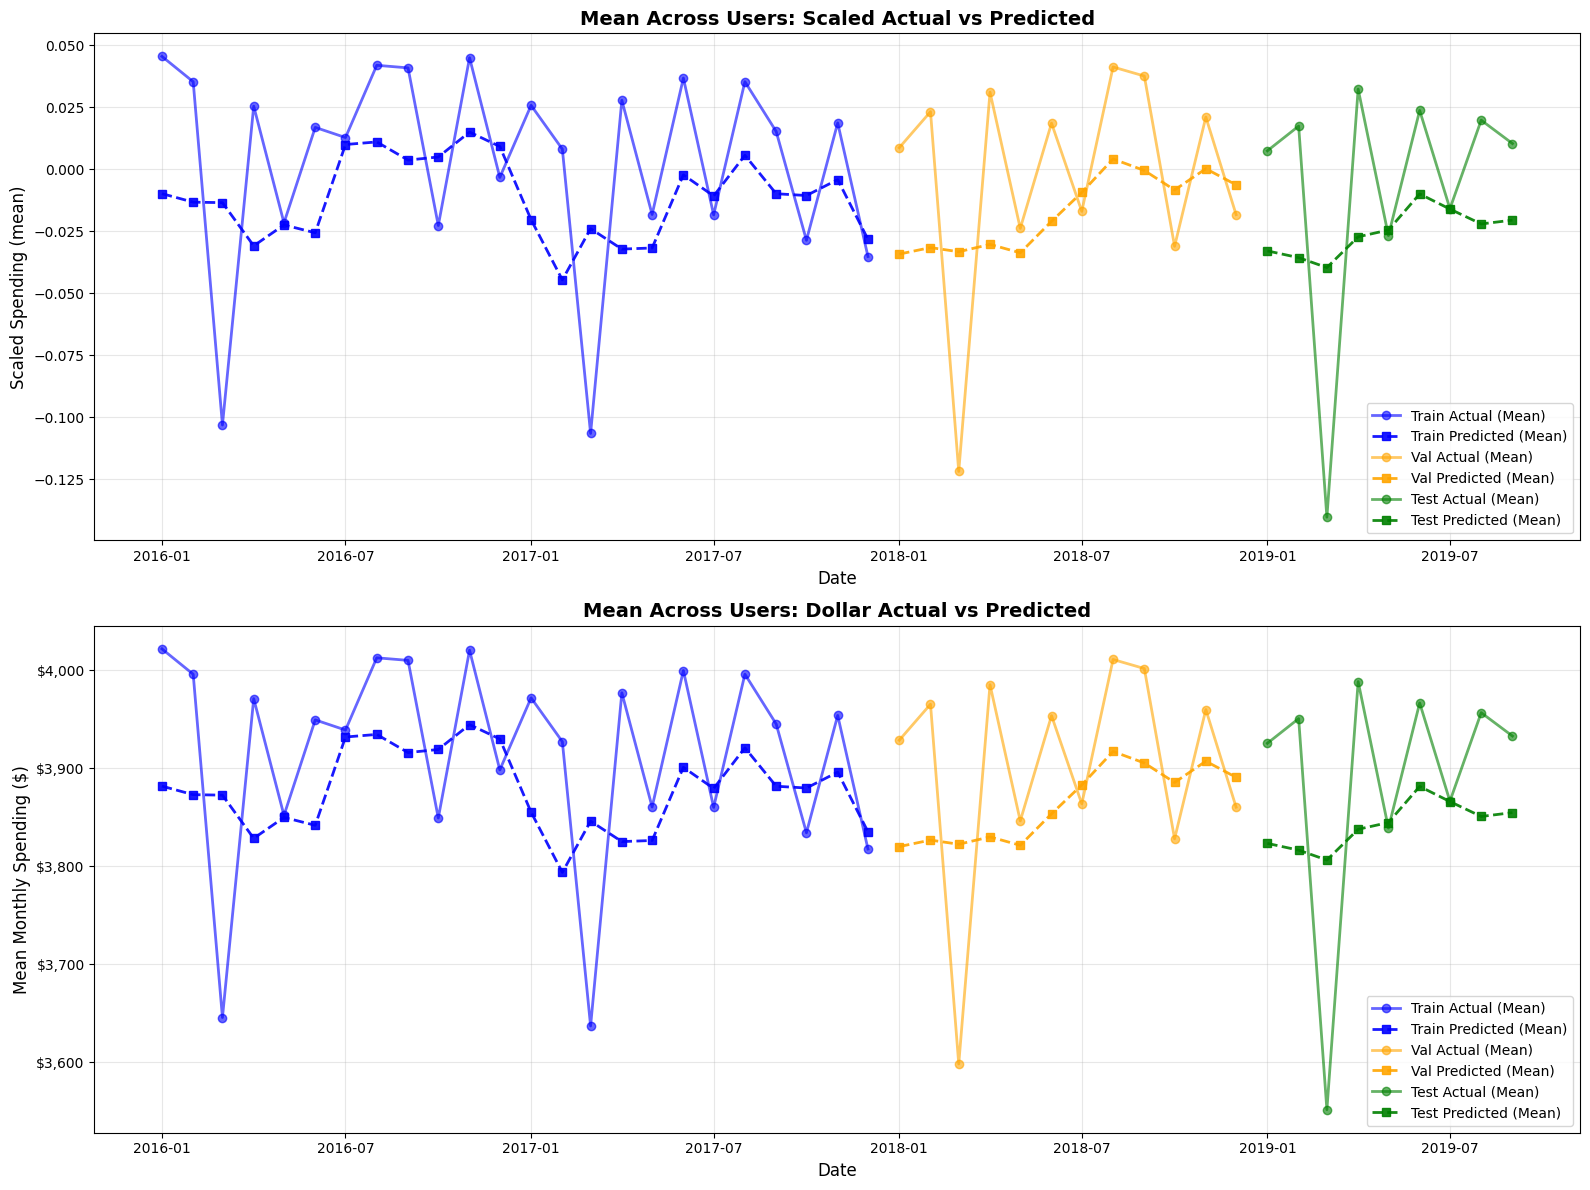


📊 Mean Predictions Statistics Across All Users

TRAIN SET (24 months):
  Mean Actual: $3,914.46
  Mean Predicted: $3,877.73
  MAE: $88.36

VAL SET (12 months):
  Mean Actual: $3,900.23
  Mean Predicted: $3,863.66
  MAE: $91.78

TEST SET (9 months):
  Mean Actual: $3,886.48
  Mean Predicted: $3,842.48
  MAE: $101.85

🎯 Example User Predictions:


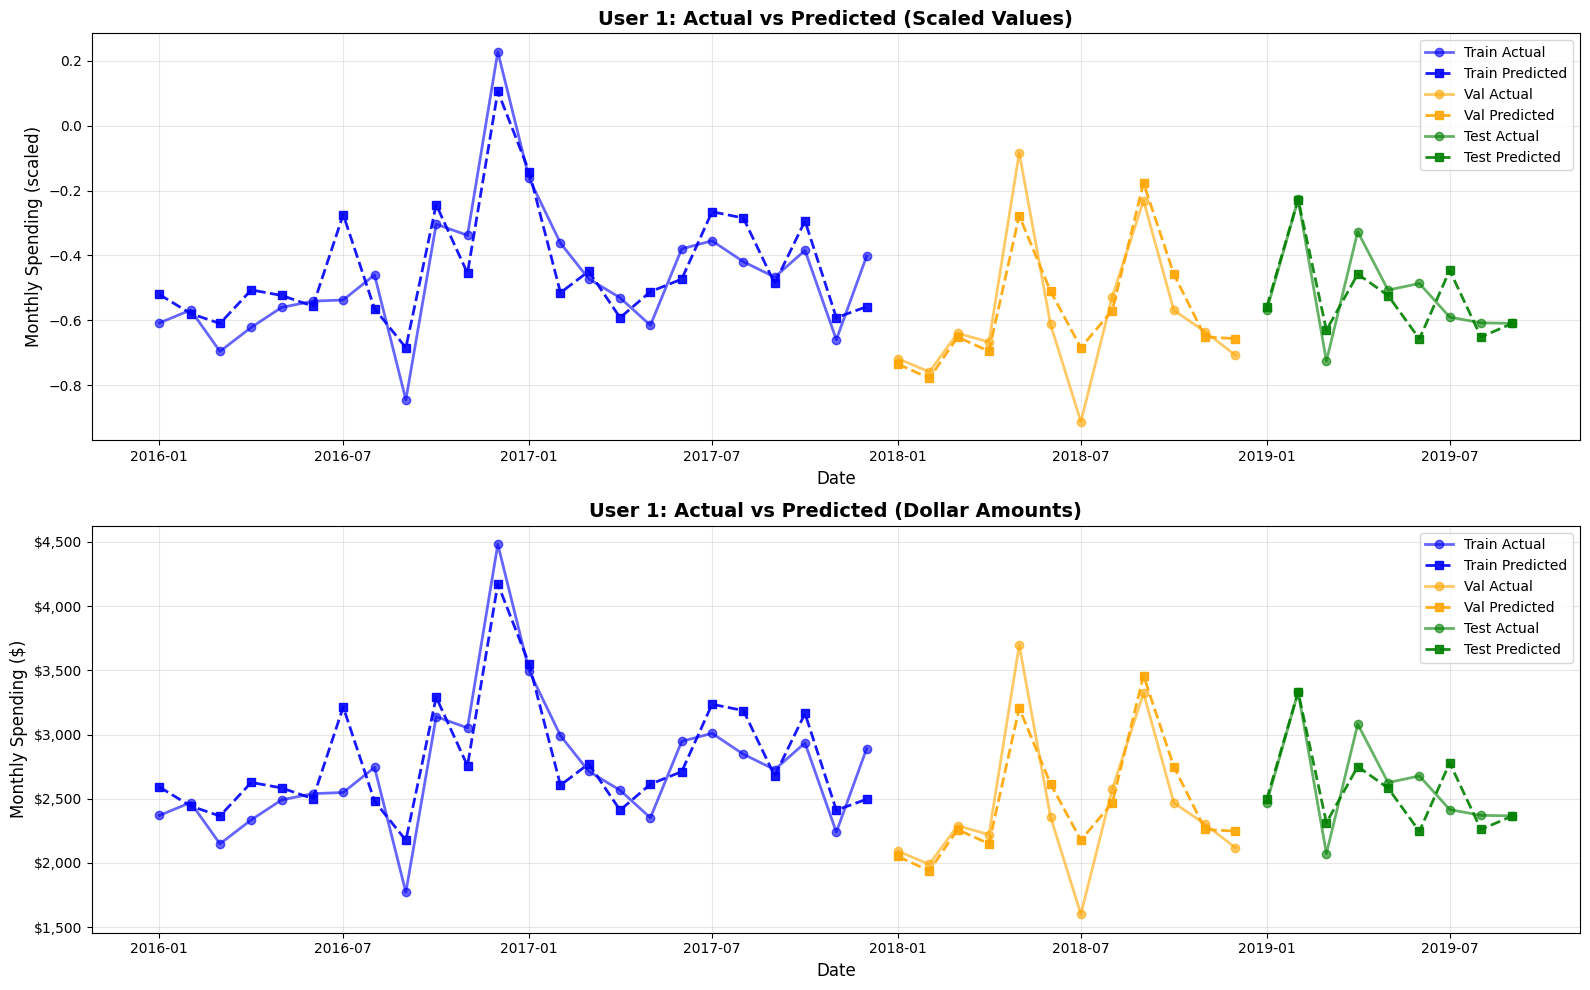

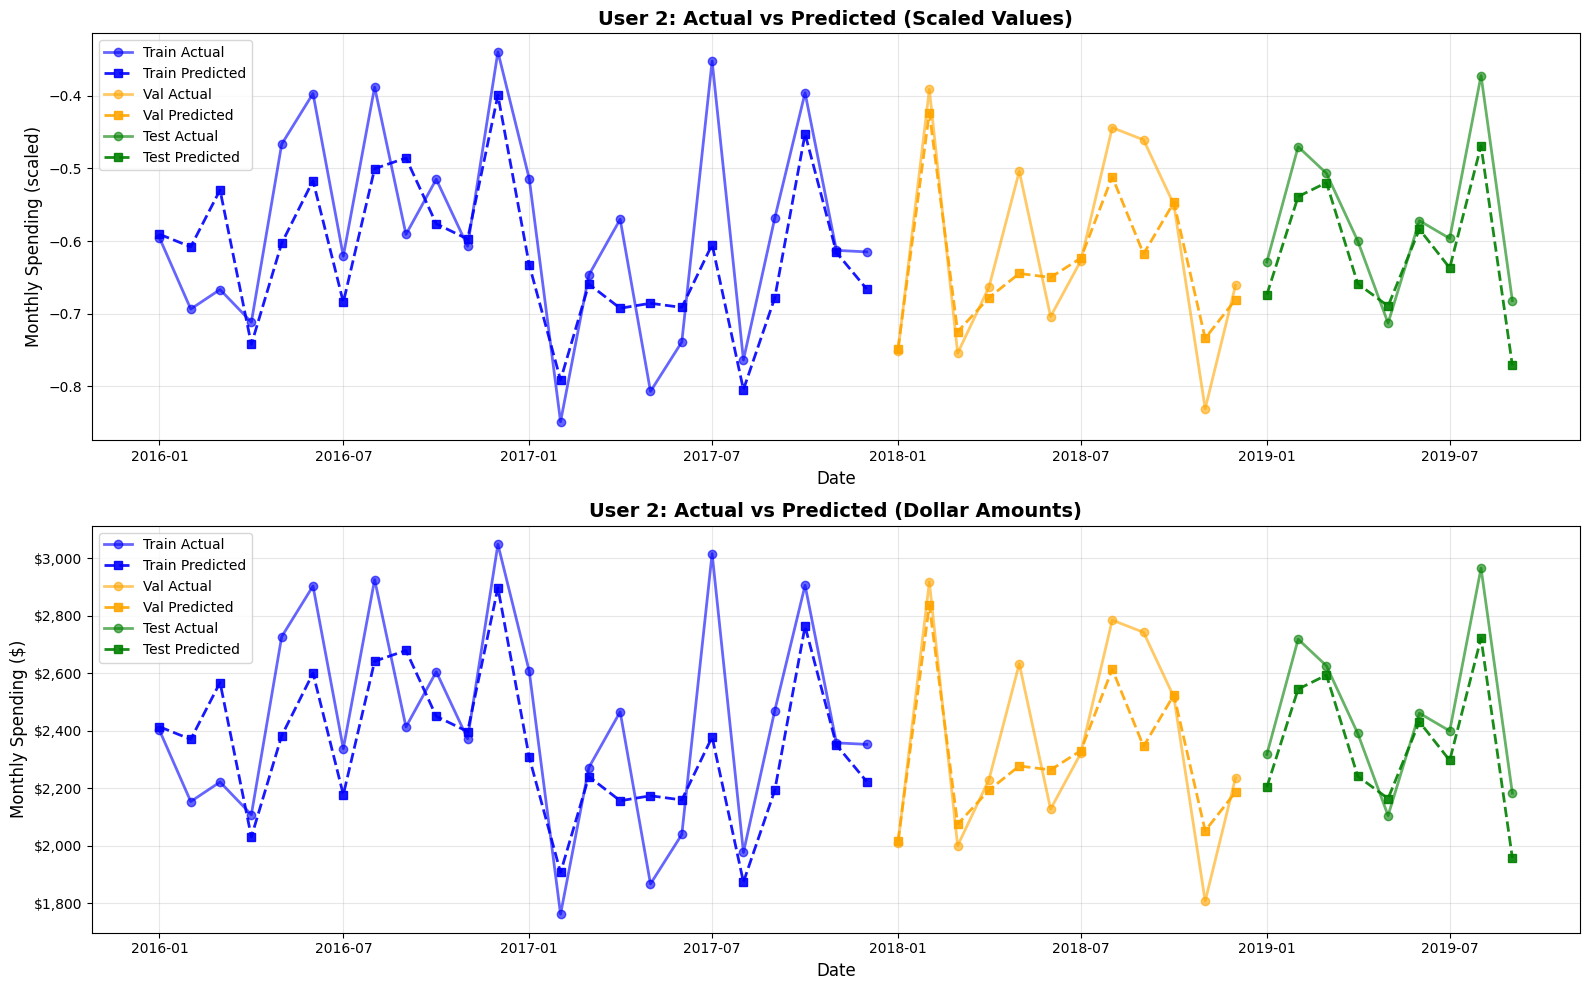

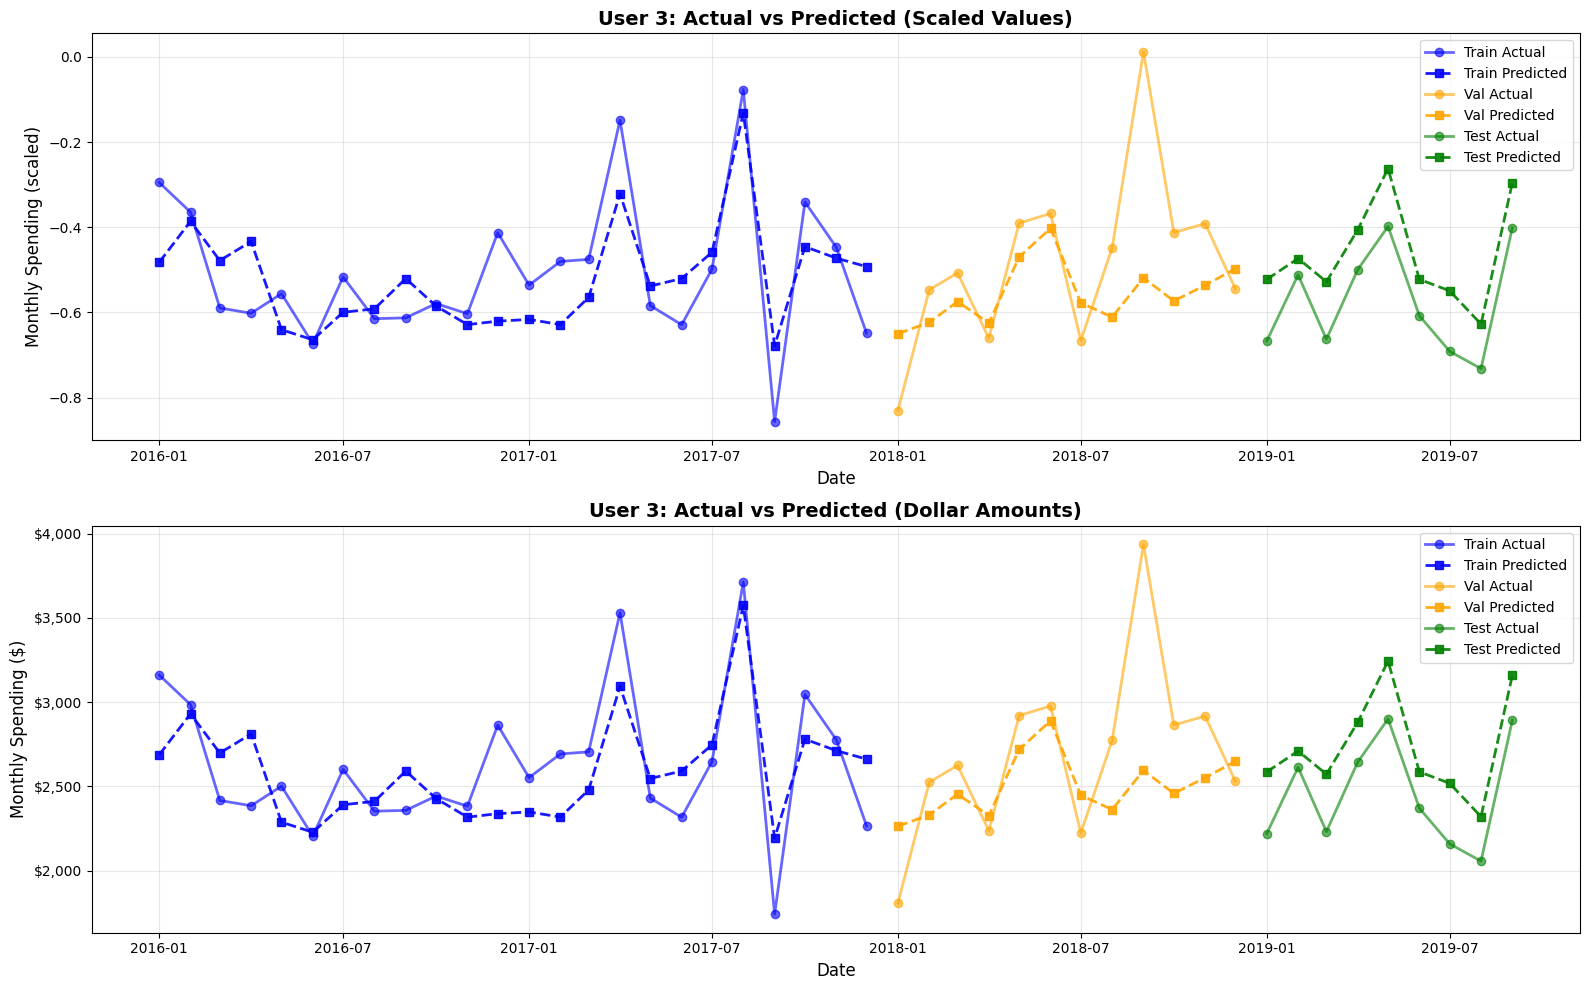

In [25]:
print("🎯 Mean Predictions Across All Users:")
print("=" * 60)
plot_predictions(plot_df)  # Aggregate mean

print("\n🎯 Example User Predictions:")
print("=" * 60)

sample_users = [1, 2, 3]
for user_id in sample_users:
    plot_predictions(plot_df, user_id=user_id)